# Import libraries

In [ ]:
import PIL
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.applications.mobilenet_v2 as mobilenet

from pathlib import Path
from livelossplot.tf_keras import PlotLossesCallback
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Preparation data

In [5]:
def preprocess_input_model(_image):
    from PIL import Image
    
    crop_image = _image.crop((20, 30, 110, 90))
    crop_image = crop_image.resize((128, 128), Image.ANTIALIAS)
    
    return crop_image

def show_images(images):
    plt.figure(figsize=(8, 8))
    
    for i in range(0, 12):
        plt.subplot(3, 4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        plt.axis(False)
        
    plt.show()

BATCH_SIZE = 24
IMG_SHAPE = 128
IMAGE_SIZE = (128, 128, 3)

path_base = r"D:\KWork\ReCaptcher"

file_source = Path(path_base) / "base"
train_file_destination = Path(path_base) / "data" / "train"
val_file_destination = Path(path_base) / "data" / "validation"

image = PIL.Image.open(train_file_destination / "airplane" / "airplane_1.png")
print(np.array(image))

In [10]:
train_dir = train_file_destination
val_dir = val_file_destination

gen_data = ImageDataGenerator(
    rescale=1/255., rotation_range=5, width_shift_range=0.1,
    height_shift_range=0.02, zoom_range=0.15, fill_mode="nearest"
)

train_data_gen = gen_data.flow_from_directory(
    directory=train_dir, target_size=(IMG_SHAPE, IMG_SHAPE),
    batch_size=BATCH_SIZE, shuffle=True, class_mode="sparse"
)

val_data_gen = gen_data.flow_from_directory(
    directory=val_dir, target_size=(IMG_SHAPE, IMG_SHAPE),
    batch_size=BATCH_SIZE, shuffle=False, class_mode="sparse"
)

Found 3809 images belonging to 8 classes.
Found 1629 images belonging to 8 classes.


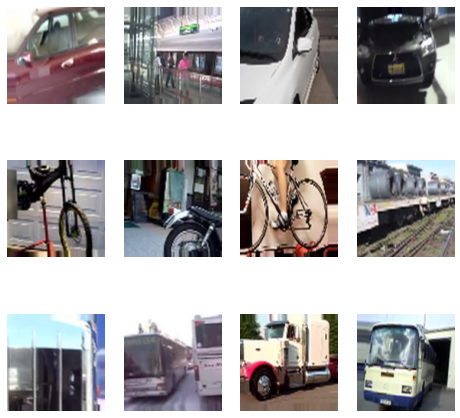

In [13]:
samples, _ = next(train_data_gen)
show_images(samples)

# Training model

In [16]:
def fit_model(model, preprocessing_func):
    EPOCHS = 50
    
    gen_data = ImageDataGenerator(
        preprocessing_function=preprocessing_func,
        rotation_range=5, width_shift_range=0.1,
        height_shift_range=0.02, zoom_range=0.15,
        fill_mode="nearest"
    )
    
    train_data_gen = gen_data.flow_from_directory(
        directory=train_dir, target_size=(IMG_SHAPE, IMG_SHAPE),
        batch_size=BATCH_SIZE, shuffle=True, class_mode="sparse"
    )

    val_data_gen = gen_data.flow_from_directory(
        directory=val_dir, target_size=(IMG_SHAPE, IMG_SHAPE),
        batch_size=BATCH_SIZE, shuffle=False, class_mode="sparse"
    )
    
    base_model = model
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(rate=0.5),
        tf.keras.layers.Dense(8, activation="softmax")
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1.5e-4),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"]
    )
    
    path = Path(f"{model.layers[0].name}")
    path.mkdir(exist_ok=True)

    filename = "best_model.hdf5"
    cpt_path = str(path / filename)
    
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        cpt_path, monitor="val_accuracy", verbose=1, save_best_only=True, mode="max"
    )

    history = model.fit(
        train_data_gen, epochs=EPOCHS,
        validation_data=val_data_gen,
        callbacks=([PlotLossesCallback(), checkpoint])
    )
    
    info = f"{model.layers[0].name} - Accuracy:{max(history.history['accuracy'])} | Val_accuracy:{max(history.history['val_accuracy'])}"
    
    return info

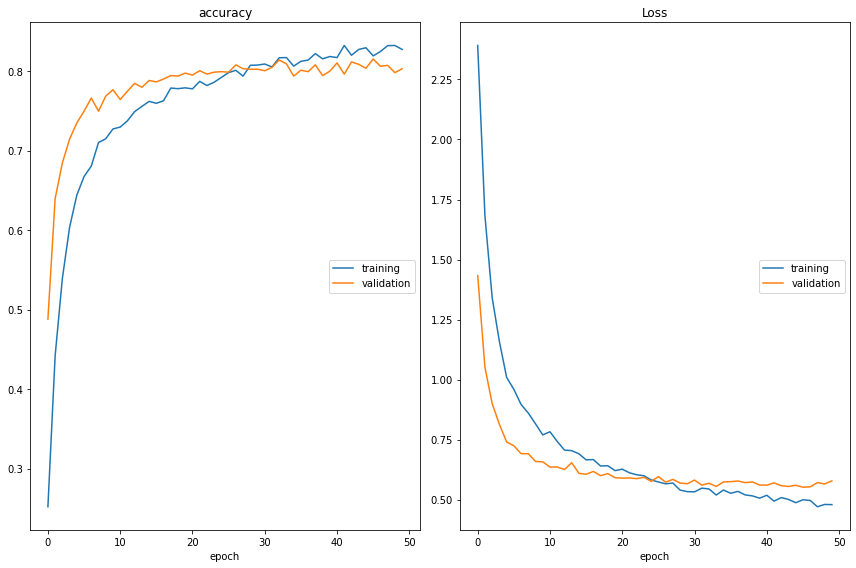

accuracy
	training         	 (min:    0.252, max:    0.832, cur:    0.827)
	validation       	 (min:    0.488, max:    0.815, cur:    0.803)
Loss
	training         	 (min:    0.471, max:    2.392, cur:    0.479)
	validation       	 (min:    0.552, max:    1.433, cur:    0.578)

Epoch 00050: val_accuracy did not improve from 0.81522


['mobilenetv2_1.00_128 - Accuracy:0.8322394490242004 | Val_accuracy:0.8152240514755249']

In [17]:
models = [
    tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False, weights="imagenet", input_shape=IMAGE_SIZE),
]

preprocessing = [
    tf.keras.applications.mobilenet_v2.preprocess_input,
]

info = []
for base_model, prep_input in zip(models, preprocessing):
    info.append(fit_model(base_model, prep_input))

info